<center><font size="6">Хакатон от Моторики</font>

[Третий этап](https://www.kaggle.com/competitions/motorica-advanced-gesture-classification)

Команда 1

**Задача:**  Построить классификационную модель, которая по показаниям оптомиографических датчиков будет определять жест оператора протеза кисти во время записи данных, что отражено в значении целевой переменной. 

Имеется три оператора, выполнявшие некоторую последовательность жестов. В результате наблюдений получены показания датчиков в виде непрерывного временного ряда. 

Список файлов, в котором символ * обозначает индекс оператора:
* X_train_*.npy - обучающая выборка, имеющая размерности "наблюдения, датчики, время";
* X_test_dataset_*.pkl - тестовая выборка, имеющая размерности "наблюдения, датчики, время";
* sample_submission.csv - некоторое решение задачи, из которого можно взять формат загрузки данных на Kaggle;
* y_train_*.npy - целевая переменная для обучающей выборки, которая содержит следующие классы:

| Номер <br> класса | Описание жеста |
| :---: | :--- |
| "-1"  |  потенциально "битые" данные |
| "0"  |  жест "open" - разгиб всех пальцев |
| "1"  |  жест "пистолет" |
| "2"  |  сгиб большого пальца |
| "3"  |  жест "ok" |
| "4"  |  жест "grab" |

* functions.py - библиотека функций, применяемых в данном ноутбуке.

# Import библиотек и описание функций

In [14]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import copy
import pickle
#import zipfile
from zipfile import ZipFile

# графические библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# отображать по умолчанию длину дата Датафрейма
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

# библиотека нормализации данных
from sklearn.preprocessing import StandardScaler

# библиотека взаимодействия с интерпретатором
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import os

# Библиотека вызова функций, специально разработанных для данного ноутбука
import functions as f

# отображение элементов массива не в научном формате
np.set_printoptions(suppress=True)

In [15]:
# константы и глобальные параметры данных
PATH = 'data/'
GEST = 5          # количество основных жестов (кроме 'битых' данных)
PL = 3            # количество пилотов (независимых рядов данных)
SENS = 50         # количество датчиков

X_train = ['' for p in range(PL)]  # список объектов X_train
y_train = ['' for p in range(PL)]  # список объектов y_train
X_test = ['' for p in range(PL)]   # список объектов X_test

t_train = ['' for p in range(PL)]   # список длин X_train и y_train (кол-во временных тиков)
t_test = [0 for p in range(PL)]     # список с общим количеством временных тиков в X_test
s_test = ['' for p in range(PL)]    # список с количеством событий в X_test
tt_test = [[] for p in range(PL)]   # список списков с длинами событий в X_test

# Загрузка данных
---

In [16]:
# Словарь для последующей агрегации данных. Изначально прописаны названия файлов в архиве
mounts = {
    1 : {
        'path_X_train' : 'X_train_1.npy',
        'path_y_train' : 'y_train_1.npy',
        'path_X_test_dataset' : 'X_test_dataset_1.pkl',
    },
    2 : {
        'path_X_train' : 'X_train_2.npy',
        'path_y_train' : 'y_train_2.npy',
        'path_X_test_dataset' : 'X_test_dataset_2.pkl',
    },
    3 : {
        'path_X_train' : 'X_train_3.npy',
        'path_y_train' : 'y_train_3.npy',
        'path_X_test_dataset' : 'X_test_dataset_3.pkl',
    }
}

In [17]:
# Чтение данных из архива (без распаковки архива)
path_to_zip = os.path.join(PATH, 'motorica-advanced-gesture-classification.zip')

for mount_name, mount in mounts.items():
    mount['X_train'] = np.load(path_to_zip)[mount['path_X_train']]
    mount['y_train'] = np.load(path_to_zip)[mount['path_y_train']]
    
    with ZipFile(path_to_zip) as myzip:
        with myzip.open(mount['path_X_test_dataset']) as myfile:
            mount['X_test_dataset'] = pickle.load(myfile)
    print(len(mount['X_test_dataset']))

899
855
861


In [18]:
f.get_signal_derivative_plot(Pilot_id=1, time_start = 100, time_end = 600, sensors=[0,2], mounts=mounts, plot_counter=1)

ValueError: Shape of passed values is (50, 1), indices imply (24030, 50)

In [ ]:
# загрузка обучающей выборки и меток классов, тестовой выборки
X_test_raw = ['' for p in range(PL)]
for p in range(PL):
    X_train[p] = mounts[p+1]['X_train']
    t_train[p] = mounts[p+1]['X_train'].shape[0]
    
    y_train[p] = mounts[p+1]['y_train']
    
    if y_train[p].size == t_train[p]:
        print(f'длина обучающей выборки пилота №{p+1} = {t_train[p]}')
    else:
        print(f'длина обучающей выборки и меток классов пилота №{p+1} не совпадают!')
    
    #with open(os.path.join(PATH, 'X_test_dataset_' + f'{p+1}' + '.pkl'), 'rb') as file:
    X_test_raw[p] = mount['X_test_dataset'][p]

длина обучающей выборки пилота №1 = 24030
длина обучающей выборки пилота №2 = 23202
длина обучающей выборки пилота №3 = 23177


In [ ]:
# смотрим на исходные данные X_train
print(f"Тип данных X_train: {type(mounts[1]['X_train'])}")
print(f"Размерность файла X_train_1: {mounts[1]['X_train'].shape} - время, датчики")
print(f"X_train первого пилота: \n {mounts[1]['X_train']}")

Тип данных X_train: <class 'numpy.ndarray'>
Размерность файла X_train_1: (24030, 50) - время, датчики
X_train первого пилота: 
 [[2711   16 1803 ...    8   14    7]
 [2712   10 1802 ...    6   12    6]
 [2711   13 1803 ...    5   16    8]
 ...
 [2707   16 1851 ...    6   13    6]
 [2707   18 1850 ...    8   12    6]
 [2710   16 1851 ...    9   11    8]]


In [ ]:
# смотрим на исходные данные y_train
print(f"Тип данных y_train: {type(mounts[1]['y_train'])}")
print(f"Размерность файла y_train_1: {mounts[1]['y_train'].shape} - время")
print(f"y_train первого пилота: \n {mounts[1]['y_train']}")

Тип данных y_train: <class 'numpy.ndarray'>
Размерность файла y_train_1: (24030,) - время
y_train первого пилота: 
 [0 0 0 ... 3 3 3]


In [ ]:
# транспонируем np.array для каждого события в X_test
# t_test = [0 for p in range(PL)]
# X_test = copy.deepcopy(X_test_raw)
# for p in range(PL):
#     s_test[p] = len(X_test_raw[p])
#     print(f'Количество событий для пилота №{p+1} = {s_test[p]}')
#     for s in range(s_test[p]):
#         X_test[p][s] = X_test[p][s].T
#         tt_test[p].append(len(X_test[p][s]))
#         t_test[p] += tt_test[p][s]
# print(f'X_test первого пилота содержит всего {t_test[0]} временных тиков')
# print(f'X_test первого пилота, событие "0" длиной {tt_test[0][0]} тиков:')
# X_test[0][0]

## Обзор файла `X_test_dataset`

In [ ]:
mount['X_test_dataset'][1].shape

(50, 256)

In [ ]:
# смотрим на исходные данные X_test
print(f"Тип данных X_test: {type(mount['X_test_dataset'])}")
print(f"Тип данных X_test для пилота 1: {type(mount['X_test_dataset'][1])}")
print(f"Размерность файла X_test_1: {mount['X_test_dataset'][1].shape} - время, датчики")
print(f"X_test первого пилота, наблюдение '0': \n {mount['X_test_dataset'][1][0]}")

Тип данных X_test: <class 'list'>
Тип данных X_test для пилота 1: <class 'numpy.ndarray'>
Размерность файла X_test_1: (50, 256) - время, датчики
X_test первого пилота, наблюдение '0': 
 [1370 1372 1369 1363 1361 1356 1354 1354 1353 1350 1352 1356 1359 1359
 1359 1358 1358 1360 1359 1359 1358 1356 1355 1355 1354 1355 1356 1359
 1363 1361 1362 1366 1365 1367 1366 1371 1386 1395 1395 1368 1342 1317
 1291 1272 1254 1235 1213 1194 1176 1163 1145 1131 1121 1111 1108 1106
 1108 1115 1119 1118 1117 1115 1112 1113 1113 1113 1111 1110 1110 1109
 1110 1108 1106 1111 1110 1111 1110 1113 1110 1109 1110 1111 1113 1112
 1112 1112 1112 1114 1114 1114 1116 1115 1118 1117 1113 1115 1116 1146
 1197 1236 1271 1291 1300 1303 1309 1317 1327 1332 1340 1349 1355 1361
 1367 1371 1371 1379 1387 1400 1408 1413 1415 1416 1421 1427 1429 1428
 1426 1425 1425 1420 1418 1415 1411 1408 1408 1406 1405 1407 1404 1405
 1404 1405 1401 1402 1402 1403 1402 1402 1403 1402 1401 1398 1398 1395
 1396 1397 1396 1395 1392 1391 13

In [ ]:
for mount_name, mount in mounts.items():
    X_test_dataset = mount['X_test_dataset']
    print(f"subject {mount_name}")
    shapes, counts = np.unique(
        [arr.shape for arr in X_test_dataset],
        return_counts=True,
        axis=0
    )
    for shape, count in zip(shapes, counts):
        print(f"\tshape {tuple(shape)} appears {count} times.")

subject 1
	shape (50, 105) appears 303 times.
	shape (50, 181) appears 299 times.
	shape (50, 256) appears 297 times.
subject 2
	shape (50, 105) appears 286 times.
	shape (50, 181) appears 285 times.
	shape (50, 256) appears 284 times.
subject 3
	shape (50, 105) appears 291 times.
	shape (50, 181) appears 282 times.
	shape (50, 256) appears 288 times.


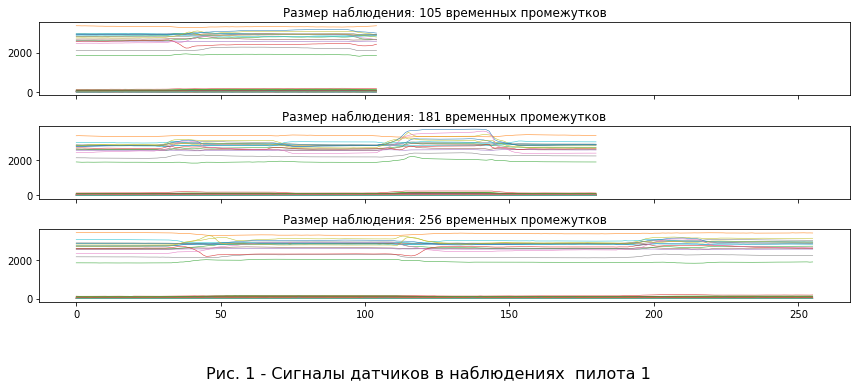

In [ ]:
# Отобразим три различных наблюдения первого пилота
from tkinter import font


plot_counter=1

for mount_name, mount in mounts.items():
    X_test_dataset = mount['X_test_dataset']
    
    fig, axx = plt.subplots(3, 1, sharex=True, figsize=(12, 5))

    test_id = 3  # номер наблюдения 
    plt.sca(axx[0])
    plt.plot(X_test_dataset[test_id].T, lw=0.5)
    plt.title(f'Размер наблюдения: {X_test_dataset[test_id][mount_name].T.shape[0]} временных промежутков')
    
    test_id = 1  # номер наблюдения
    plt.sca(axx[1])
    plt.plot(X_test_dataset[test_id].T, lw=0.5)
    plt.title(f'Размер наблюдения: {X_test_dataset[test_id][mount_name].T.shape[0]} временных промежутков')
    
    test_id = 8  # номер наблюдения
    plt.sca(axx[2])
    plt.plot(X_test_dataset[test_id].T, lw=0.5)
    plt.title(f'Размер наблюдения: {X_test_dataset[test_id][mount_name].T.shape[0]} временных промежутков')
    
    plt.suptitle(f"Рис. {plot_counter} - Сигналы датчиков в наблюдениях  пилота {mount_name}", y=-0.1, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    break

In [ ]:
print('X_train первого пилота:')
X_train[0].shape

X_train первого пилота:


(24030, 50)

In [ ]:
active_sensors, passive_sensor = f.get_sensor_list(0, X_train, print_active=True)

Активные датчики пилота 0:  [0, 2, 5, 8, 12, 15, 17, 19, 21, 24, 27, 29, 30, 33, 36, 38]
Пассивные датчики пилота 0:  [1, 3, 4, 6, 7, 9, 10, 11, 13, 14, 16, 18, 20, 22, 23, 25, 26, 28, 31, 32, 34, 35, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [ ]:
f.get_all_sensors_plot(1, [0,107], X_train, plot_counter=2)

In [ ]:
f.get_active_passive_sensors_plot(1, X_train, plot_counter=3)

# Поиск периода времени, в котором изменился класс жеста

Проанализируем показания датчика 2

In [ ]:
f.get_signal_derivative_plot(Pilot_id=1, time_start = 100, time_end = 600, sensors=([0,2]), X_train=mounts[1]['X_train'], y_train=mounts[1]['y_train'], plot_counter=1)

IndexError: tuple index out of range

In [29]:
len(mounts[1]['X_train'][0])

50

In [30]:
len(mounts[1]['X_train'])

24030

In [32]:
mounts[1]['X_train']

array([[2711,   16, 1803, ...,    8,   14,    7],
       [2712,   10, 1802, ...,    6,   12,    6],
       [2711,   13, 1803, ...,    5,   16,    8],
       ...,
       [2707,   16, 1851, ...,    6,   13,    6],
       [2707,   18, 1850, ...,    8,   12,    6],
       [2710,   16, 1851, ...,    9,   11,    8]], dtype=int64)

In [31]:
Pilot_id = 1
time_start = 100
time_end = 600
sensors = list([0, 2, #5, 8, 12, 15, 17, 19, 21, 24, 27, 29, 30, 33, 36, 38
])

plot_counter = 6

timesteps=[time_start, time_end]


df_1 = pd.DataFrame(
    data = mounts[Pilot_id]['X_train'], 
    index =   [s for s in range(len(mounts[Pilot_id]['X_train']))], 
    columns = [s for s in range(len(mounts[Pilot_id]['X_train'][0]))]
    ).iloc[timesteps[0]:timesteps[1],:][sensors]
    
# Нормализация данных
scaler = StandardScaler()
scaler.fit(df_1)
df_1 = pd.DataFrame(scaler.transform(df_1))

fig = make_subplots(rows=2, cols=2, 
    subplot_titles=(f'X_train - нормализованные сигналы', 'y_train', 
    f'Производная нормализованных сигналов датчиков', f'Квадрат производной нормализованных сигналов датчиков'), vertical_spacing = 0.1,
)

for i in df_1.columns: 
    fig.add_trace(go.Scatter(x=df_1.index, y=df_1[i], name=str(df_1[i].name)), row=1, col=1)

df_2 = pd.DataFrame(data = y_train[Pilot_id], index = [s for s in range(y_train[Pilot_id].shape[0])]).iloc[timesteps[0]:timesteps[1],:]

for i in df_2.columns: 
    fig.add_trace(go.Scatter(x=df_1.index, y=df_2[i], name=str(df_1[i].name)), row=2, col=1)


df_3 = pd.DataFrame(df_1.diff(), index = range(df_1.index[0], df_1.index[-1]+1))


for i in df_3.columns: 
    fig.add_trace(go.Scatter(x=df_1.index, y=df_1[i], name=str(df_1[i].name)), row=1, col=2)

#  датасет квадрата производной
df_4 = pd.DataFrame(np.power(df_1.diff(),2), index = range(df_1.index[0], df_1.index[-1]+1))

for i in df_4.columns: 
    fig.add_trace(go.Scatter(x=df_1.index, y=df_4[i], name=str(df_4[i].name)), row=2, col=2)

fig.update_layout(title={'text':f'Рис. {plot_counter} - Нормализованные сигналы датчиков {sensors} пилота {Pilot_id}', 
'x':0.5, 'y':0.01}
)

fig.update_layout(width=1200, height=800, legend_title_text ='Номер датчика',
                    xaxis_title_text  = 'Время',  yaxis_title_text = 'Сигнал датчика', #yaxis_range=[1500, 1700], 
                    xaxis2_title_text = 'Время', yaxis2_title_text = 'Жест', #yaxis2_range= [0 , 200],
                    margin=dict(l=40, r=60, t=30, b=80), 
                    showlegend=False # легенда загромождает картинку
)

fig.show()

AttributeError: 'str' object has no attribute 'shape'